In [163]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.inspection import permutation_importance
import torch
from datetime import datetime
import os
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

In [124]:
# Step 1: Load the CSV files
psei_df = pd.read_csv('psei_historical.csv')
php_usd_df = pd.read_csv('php_to_usd.csv')
sp500_df = pd.read_csv('sp500_index.csv')
inflation_df = pd.read_csv('inflation_philippines.csv')
interest_df = pd.read_csv('bank_interest_rate.csv')

In [125]:
# Function to convert 'Trade' values with 'K' suffix to float
def convert_trade_to_float(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    return float(value)

In [126]:
# Clean PSEI data
# Convert columns to string if they are not already
psei_df['Volume'] = psei_df['Volume'].astype(str)
psei_df['Net Foreign'] = psei_df['Net Foreign'].astype(str)
psei_df['Change Percent'] = psei_df['Change Percent'].astype(str)

psei_df['Volume'] = psei_df['Volume'].str.replace('M', 'e6').str.replace('B', 'e9').astype(float)
psei_df['Net Foreign'] = psei_df['Net Foreign'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('B', 'e9').astype(float)
psei_df['Change Percent'] = psei_df['Change Percent'].str.replace('%', '').astype(float)

In [127]:
# Clean PHP to USD data
php_usd_df['Change Percent'] = php_usd_df['Change Percent'].str.replace('%', '').astype(float)

In [128]:
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

In [129]:
psei_df['Date'] = pd.to_datetime(psei_df['Date'])

In [130]:
psei_df['Last Price'] = psei_df['Last Price'].str.replace(',', '').astype(float)

In [131]:
php_usd_df['Date'] = pd.to_datetime(php_usd_df['Date'])

In [132]:
# Apply the conversion function to the 'Trade' column
psei_df['Trade'] = psei_df['Trade'].apply(convert_trade_to_float)

In [133]:
# Melt inflation data to long format
inflation_long = pd.melt(inflation_df, id_vars=['Month'], 
                        value_vars=['2021', '2022', '2023', '2024', '2025'],
                        var_name='Year', value_name='Inflation_Rate')
inflation_long['Date'] = pd.to_datetime(inflation_long['Year'] + '-' + 
                                       inflation_long['Month'] + '-01', format='%Y-%B-%d')
inflation_long = inflation_long.drop(columns=['Month', 'Year'])

In [134]:
# Melt interest rate data to long format
interest_long = pd.melt(interest_df, id_vars=['Month'], 
                       value_vars=['2023', '2024', '2025'],
                       var_name='Year', value_name='Interest_Rate')
interest_long['Date'] = pd.to_datetime(interest_long['Year'] + '-' + 
                                      interest_long['Month'] + '-01', format='%Y-%B-%d')
interest_long = interest_long.drop(columns=['Month', 'Year'])

In [135]:
inflation_long['Date'] = pd.to_datetime(inflation_long['Date'])

In [136]:
print(php_usd_df.head())

        Date  Last Price  Change  Change Percent
0 2025-04-04      57.411   0.404            0.71
1 2025-04-03      57.007  -0.214           -0.37
2 2025-04-02      57.221   0.019            0.03
3 2025-04-01      57.202  -0.049           -0.09
4 2025-03-31      57.251  -0.104           -0.18


In [137]:
# Step 3: Merge the datasets
# Merge daily datasets
daily_merged = pd.merge(psei_df, php_usd_df, on='Date', how='outer', suffixes=('_PSEI', '_PHP_USD'))
# original merged - >      daily_merged = pd.merge(daily_merged, sp500_df, on='Date', how='outer')


In [138]:
# Merge with monthly datasets
merged_df = pd.merge(daily_merged, inflation_long, on='Date', how='left')
merged_df = pd.merge(merged_df, interest_long, on='Date', how='left')

In [139]:
# Forward and backward fill monthly data
merged_df['Inflation_Rate'] = merged_df['Inflation_Rate'].ffill().bfill()
merged_df['Interest_Rate'] = merged_df['Interest_Rate'].ffill().bfill()

In [140]:
# Step 4: Feature engineering
# Create lagged features for PSEI Last Price
merged_df = merged_df.sort_values('Date')

# Set the first row of Lag1 to equal the first row of Last Price
merged_df.loc[merged_df.index[0], 'Last_Price_PSEI_Lag1'] = merged_df.loc[merged_df.index[0], 'Last Price_PSEI']
# merged_df.loc[merged_df.index[1], 'Last_Price_PSEI_Lag2'] = merged_df.loc[merged_df.index[0], 'Last_Price_PSEI_Lag2']

merged_df['Last_Price_PSEI_Lag1'] = merged_df['Last Price_PSEI'].shift(1)  # Previous day's price
# merged_df['Last_Price_PSEI_Lag2'] = merged_df['Last Price_PSEI'].shift(2)  # Two days ago
merged_df['Last_Price_PSEI_Lag2'] = merged_df['Last Price_PSEI'].shift(7)  # Two days ago
# Create the interaction term
merged_df['Change_x_Per_Inflation'] = merged_df['Change_PSEI'] * merged_df['Inflation_Rate']
# Step 1: Transform Volume (which is always positive in your dataset)
merged_df['Log_Volume'] = np.log(merged_df['Volume'] + 1)
merged_df['Log_Trade'] = np.log(merged_df['Trade'] + 1)

merged_df['Share'] = merged_df['Share'].str.replace('B', '').str.replace('M', '')
merged_df['Share'] = merged_df['Share'].astype(float)
merged_df['Log_Share'] = np.log(merged_df['Share'] + 1)

# Step 2: Transform Net Foreign (which has negative values)
# Use a signed log transformation: sign(x) * log(|x| + 1)
merged_df['Log_Net_Foreign'] = np.sign(merged_df['Net Foreign']) * np.log(np.abs(merged_df['Net Foreign']) + 1)



In [141]:
# Step 5: Prepare data for modeling
# Drop rows with missing target (Last Price_PSEI)
merged_df = merged_df.dropna(subset=['Last Price_PSEI'])
merged_df = merged_df.drop('Change_PSEI', axis=1)
merged_df = merged_df.drop('Volume', axis=1)
merged_df = merged_df.drop('Net Foreign', axis=1)
merged_df = merged_df.drop('Trade', axis=1)
merged_df = merged_df.drop('Share', axis=1)
merged_df = merged_df.dropna()

In [142]:
merged_df = merged_df[merged_df['Date'] >= '2024-07-13']

In [143]:
merged_df.to_csv('merged_data.csv', index=False)

In [144]:
# Define features (X) and target (y)
features = ['Last_Price_PSEI_Lag1', 'Last_Price_PSEI_Lag2',
            'Log_Volume', 'Log_Net_Foreign','Last Price_PHP_USD', 'Inflation_Rate', 'Interest_Rate','Change_x_Per_Inflation']
X = merged_df[features].fillna(0)  # Fill remaining NaNs with 0 (e.g., for S&P500)
y = merged_df['Last Price_PSEI']

In [145]:
# Display the first few rows of the DataFrame
print(merged_df)


          Date  Last Price_PSEI  Change Percent_PSEI  Last Price_PHP_USD  \
177 2024-07-16          6667.09                -0.33             58.3770   
176 2024-07-17          6687.71                 0.31             58.2700   
175 2024-07-18          6705.01                 0.26             58.3300   
174 2024-07-19          6791.69                 1.29             58.4005   
172 2024-07-23          6753.12                 0.61             58.4600   
..         ...              ...                  ...                 ...   
6   2025-03-26          6166.05                 0.10             57.7300   
5   2025-03-27          6139.51                -0.43             57.3790   
4   2025-03-28          6147.44                 0.13             57.3700   
1   2025-04-03          6145.73                -1.63             57.0070   
0   2025-04-04          6084.19                -1.00             57.4110   

     Change_PHP_USD  Change Percent_PHP_USD  Inflation_Rate  Interest_Rate  \
177      

In [146]:
merged_df = merged_df.dropna()
print(merged_df)

          Date  Last Price_PSEI  Change Percent_PSEI  Last Price_PHP_USD  \
177 2024-07-16          6667.09                -0.33             58.3770   
176 2024-07-17          6687.71                 0.31             58.2700   
175 2024-07-18          6705.01                 0.26             58.3300   
174 2024-07-19          6791.69                 1.29             58.4005   
172 2024-07-23          6753.12                 0.61             58.4600   
..         ...              ...                  ...                 ...   
6   2025-03-26          6166.05                 0.10             57.7300   
5   2025-03-27          6139.51                -0.43             57.3790   
4   2025-03-28          6147.44                 0.13             57.3700   
1   2025-04-03          6145.73                -1.63             57.0070   
0   2025-04-04          6084.19                -1.00             57.4110   

     Change_PHP_USD  Change Percent_PHP_USD  Inflation_Rate  Interest_Rate  \
177      

In [147]:
# Step 6: Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [148]:
# Step 7: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [149]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [150]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [151]:
# Initialize the model, loss function, and optimizer
input_size = X_train_scaled.shape[1]
model = SimpleNN(input_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)  # Learning rate scheduler

# Training loop
best_loss = float('inf')
val_loss =float('inf')
patience =  100000 # Early stopping patience
no_improvement = 0

In [152]:
# Training loop
# Create a unique directory for this training run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f'saved_models/run_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

num_epochs = 14000
for epoch in range(num_epochs):
    # Forward pass: Compute predictions
    y_pred_tensor = model(X_train_tensor)
    
    # Compute loss
    loss = criterion(y_pred_tensor, y_train_tensor)

    # Backward pass: Compute gradients
    optimizer.zero_grad()  # Reset gradients
    loss.backward()  # Compute gradients
    
    # Update weights and biases
    optimizer.step()

    # Print loss every 100 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        print("Best Loss", best_loss)
        print("Val Loss", val_loss)
        print("---------------------")

        # Save the best model with epoch number
        save_path = f"{save_dir}/best_model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, save_path)
        
        # Optional: Keep a reference to the current best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, f"{save_dir}/current_best.pth")
    else:
        no_improvement += 1
    
    if no_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch [500/14000], Loss: 36623124.0000
Epoch [1000/14000], Loss: 6991356.5000
Epoch [1500/14000], Loss: 2136867.0000
Epoch [2000/14000], Loss: 1209121.8750
Epoch [2500/14000], Loss: 689734.2500
Epoch [3000/14000], Loss: 383381.4375
Epoch [3500/14000], Loss: 217569.1094
Epoch [4000/14000], Loss: 117098.3828
Epoch [4500/14000], Loss: 61116.5234
Epoch [5000/14000], Loss: 35437.4766
Epoch [5500/14000], Loss: 23144.9062
Epoch [6000/14000], Loss: 16253.5732
Epoch [6500/14000], Loss: 11752.7744
Epoch [7000/14000], Loss: 8625.6934
Epoch [7500/14000], Loss: 6335.6333
Epoch [8000/14000], Loss: 4933.2339
Epoch [8500/14000], Loss: 3933.8618
Epoch [9000/14000], Loss: 3037.3108
Epoch [9500/14000], Loss: 2188.5786
Epoch [10000/14000], Loss: 1621.6804
Epoch [10500/14000], Loss: 1278.3557
Epoch [11000/14000], Loss: 1043.0730
Epoch [11500/14000], Loss: 860.3770
Epoch [12000/14000], Loss: 691.1758
Epoch [12500/14000], Loss: 543.4733
Epoch [13000/14000], Loss: 396.1207
Epoch [13500/14000], Loss: 320.5993


In [153]:
# Step 9: Make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

In [154]:
# Step 10: Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, y_pred)

# Print RMSE and R-squared
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Root Mean Squared Error (RMSE): 60.95
R-squared (R2): 0.52


In [155]:
# Save the final model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, f"{save_dir}/final_model.pth")

print("Training complete. Model saved.")

Training complete. Model saved.


In [156]:
# Step 12: Extract first layer weights as a proxy for feature importance
weights = model.fc1.weight.data.numpy()
# Sum the absolute weights for each input feature across all neurons in the first layer
feature_weights = np.abs(weights).mean(axis=0)

weight_importance = pd.DataFrame({
    'Feature': features,
    'Weight': feature_weights
}).sort_values(by='Weight', ascending=False)
print("\nApproximate Feature Importance (First Layer Weights):")
print(weight_importance)

# Step 13: Permutation importance (alternative method)
# Wrap the PyTorch model for scikit-learn compatibility
from sklearn.base import BaseEstimator, RegressorMixin

class PyTorchWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        return self  # Already trained
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            return self.model(X_tensor).numpy().flatten()

# Compute permutation importance
wrapped_model = PyTorchWrapper(model)
perm_importance = permutation_importance(wrapped_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)
print("\nPermutation Importance:")
print(perm_importance_df)


Approximate Feature Importance (First Layer Weights):
                  Feature    Weight
6           Interest_Rate  2.668639
5          Inflation_Rate  2.661591
3         Log_Net_Foreign  1.491859
4      Last Price_PHP_USD  0.932130
0    Last_Price_PSEI_Lag1  0.798593
7  Change_x_Per_Inflation  0.765146
1    Last_Price_PSEI_Lag2  0.652550
2              Log_Volume  0.357070

Permutation Importance:
                  Feature  Importance
0    Last_Price_PSEI_Lag1    1.588742
7  Change_x_Per_Inflation    1.546601
2              Log_Volume    0.201226
3         Log_Net_Foreign    0.050012
5          Inflation_Rate    0.000000
6           Interest_Rate    0.000000
4      Last Price_PHP_USD   -0.046913
1    Last_Price_PSEI_Lag2   -0.050709


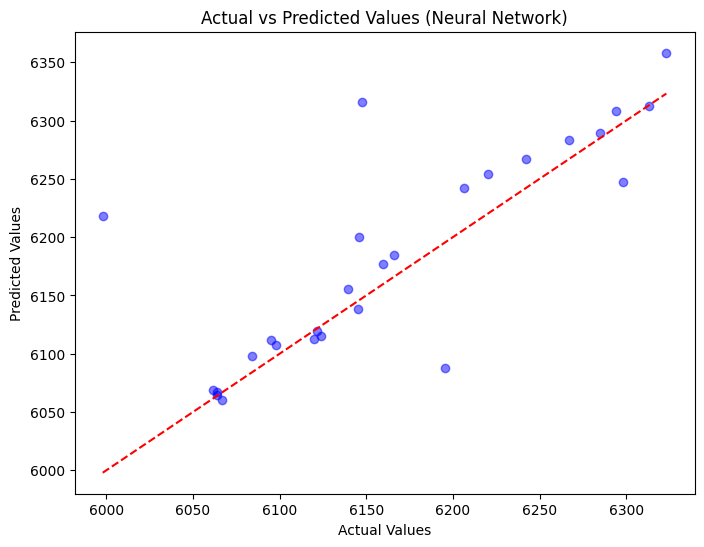

Ridge RMSE: 10.560680682366556
Ridge R-squared: 0.9856320985078848


In [157]:
# Plot actual vs. predicted for Neural Network
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Neural Network)')
plt.show()

# --- Add Ridge and Lasso Regression ---
# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # alpha controls the strength of the L2 penalty
ridge_model.fit(X_train_scaled, y_train)

# Predict with Ridge
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate Ridge
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge RMSE: {rmse_ridge}")
print(f"Ridge R-squared: {r2_ridge}")

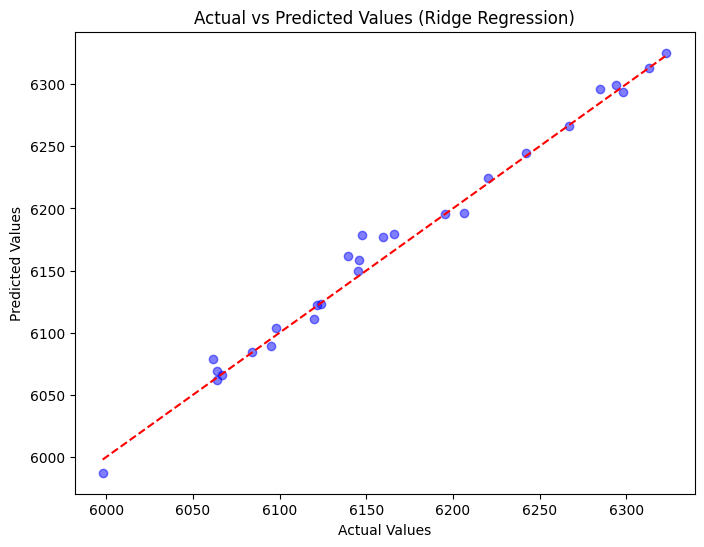

Lasso RMSE: 2.7364702163764707
Lasso R-squared: 0.999035302905505


In [158]:
# Plot actual vs. predicted for Ridge
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Ridge Regression)')
plt.show()

# Lasso Regression
lasso_model = Lasso(alpha=1.0)  # alpha controls the strength of the L1 penalty
lasso_model.fit(X_train_scaled, y_train)

# Predict with Lasso
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate Lasso
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso RMSE: {rmse_lasso}")
print(f"Lasso R-squared: {r2_lasso}")

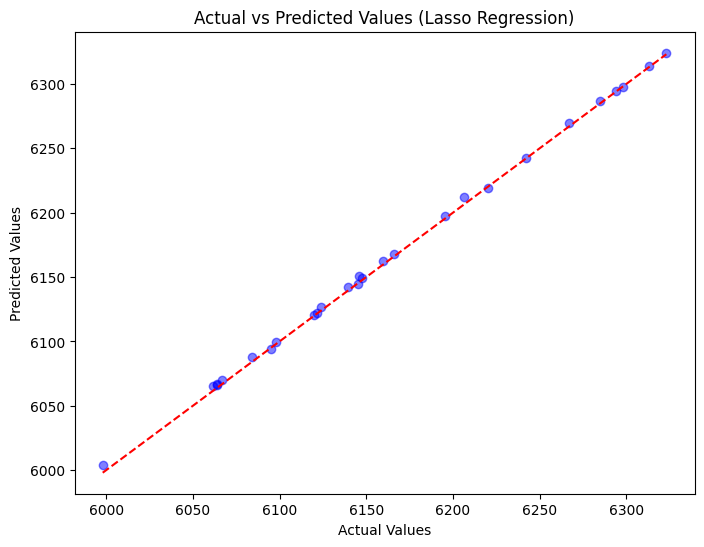

Lasso Coefficients:
                  Feature   Coefficient
0    Last_Price_PSEI_Lag1  4.018914e+02
1    Last_Price_PSEI_Lag2  4.558378e-01
2              Log_Volume -0.000000e+00
3         Log_Net_Foreign  0.000000e+00
4      Last Price_PHP_USD -5.383206e-01
5          Inflation_Rate -1.189459e+00
6           Interest_Rate -3.853328e-14
7  Change_x_Per_Inflation  7.580603e+01


In [159]:
# Plot actual vs. predicted for Lasso
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Lasso Regression)')
plt.show()

# Check Lasso coefficients (to see which features were set to zero)
lasso_coef = pd.DataFrame({'Feature': features, 'Coefficient': lasso_model.coef_})
print("Lasso Coefficients:")
print(lasso_coef)

In [169]:
# Print actual vs. predicted values side by side
future_results = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'Predicted_Ridge': y_pred_ridge,
    'Predicted_Lasso': y_pred_lasso
})

print("\nActual vs Predicted Values (Future Data):")
print(future_results)


Actual vs Predicted Values (Future Data):
    Date   Actual  Predicted_Ridge  Predicted_Lasso
0     34  6061.33      6078.939168      6065.122039
1     32  6094.96      6089.681481      6094.164209
2     31  6119.88      6111.041132      6120.907479
3     30  6066.63      6066.170856      6070.089320
4     29  6098.04      6103.843007      6099.279483
5     27  6064.16      6062.099674      6067.041968
6     26  6144.96      6149.554972      6144.676009
7     25  6124.09      6122.822780      6126.500916
8     24  5997.97      5987.370330      6003.648792
9     22  6064.11      6069.176689      6065.769516
10    21  6121.77      6121.966799      6122.461068
11    20  6219.96      6224.138719      6219.230695
12    19  6298.29      6293.783332      6297.600825
13    17  6206.55      6195.979730      6212.326978
14    16  6195.26      6195.246580      6197.346281
15    15  6242.07      6244.552457      6242.519113
16    14  6294.11      6298.965637      6294.347479
17    12  6284.68    

In [164]:
# Perform cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 folds
rmse_scores = []
r2_scores = []

for train_index, val_index in tscv.split(X_train_scaled):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit the model on the training fold
    lasso_model.fit(X_train_cv, y_train_cv)

    # Predict on the validation fold
    y_pred_cv = lasso_model.predict(X_val_cv)

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    r2 = r2_score(y_val_cv, y_pred_cv)

    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print cross-validation results
print("Cross-Validation RMSE Scores:", rmse_scores)
print(f"Mean CV RMSE: {np.mean(rmse_scores):.3f}")
print(f"Standard Deviation of CV RMSE: {np.std(rmse_scores):.3f}")
print("Cross-Validation R² Scores:", r2_scores)
print(f"Mean CV R²: {np.mean(r2_scores):.3f}")
print(f"Standard Deviation of CV R²: {np.std(r2_scores):.3f}")

Cross-Validation RMSE Scores: [20.974654832894313, 22.547063669476692, 9.04688265645617, 3.474941505422634, 4.78902178690083]
Mean CV RMSE: 12.167
Standard Deviation of CV RMSE: 8.063
Cross-Validation R² Scores: [0.9842955529335685, 0.8414344446391246, 0.9984355983828865, 0.9989780250041407, 0.9990927964382236]
Mean CV R²: 0.964
Standard Deviation of CV R²: 0.062


Random Forest RMSE: 54.74844887816014
Random Forest R-squared: 0.6138525618846771


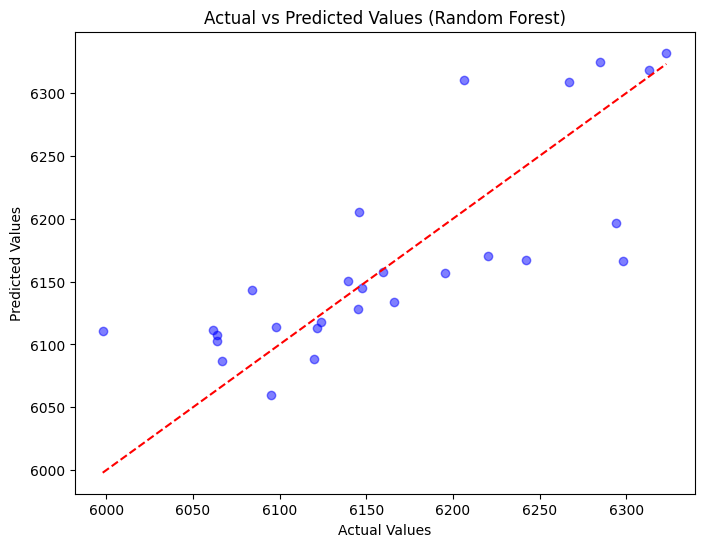

In [160]:
# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.show()

XGBoost RMSE: 72.87879495176287
XGBoost R-squared: 0.3157546020534182


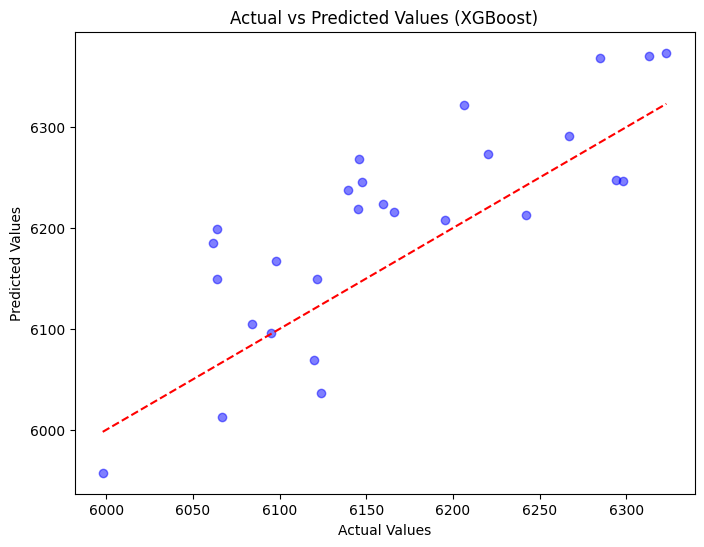

In [161]:
# Fit XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R-squared: {r2_xgb}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (XGBoost)')
plt.show()